In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim 

In [2]:
import django
import platform

if platform.node() == "mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V

In [29]:
# Defining get_coherence
# Modified for parliament 
def get_coherence(run_id):
    stat = RunStats.objects.get(run_id=run_id)
    K = stat.K
    
    # obtain utterances in run_id 
    uts = pm.Utterance.objects.filter(search_matches=par_search_tei)
    # obtain paragraphs from utterances in queryset  
    texts = []
    for ut in uts:
        pars = ut.paragraph_set.all()
        texts.append(" ".join([x.text for x in pars]))

    sentences = [get_sentence_g(x) for x in texts]
    model = gensim.models.Word2Vec(sentences)
    validation_measure = WithinTopicMeasure(
        ModelSimilarity(model)
    )

    term_rankings = []

    topics = Topic.objects.filter(
        run_id=run_id
    )

    for topic in topics:
        term_ranking = list(Term.objects.filter(
            topicterm__topic=topic
        ).order_by(
            '-topicterm__score'
        ).values_list('title',flat=True)[:50])
        term_rankings.append(term_ranking)

    stat.coherence = validation_measure.evaluate_rankings(
        term_rankings
    )
    stat.save()

    return

In [3]:
user1, created =  User.objects.get_or_create(username='leey', email='lee@mcc-berlin.net')
print(user1)
user1.save()

leey


In [35]:
user2, created =  User.objects.get_or_create(username='muef', email='mueller-hansen@mcc-berlin.net')
print(user2)
user2.save()

muef


In [36]:
# simple search for utterances
par_search_tei, created = pm.Search.objects.get_or_create(
                title="Kohle tei utterance",
                text="kohle",
                creator=user2,
                document_source="GermaParlTEI",
                search_object_type=2)
par_search_tei.save()
if created:
    print("doing search")
do_search(par_search_tei.id)
print(par_search_tei.par_count)
print(par_search_tei.utterance_count)
print(par_search_tei.runstats_set.all())

3281 utterances with search kohle
35275
3281
35298
3284
<QuerySet [<RunStats: RunStats object (1028)>, <RunStats: RunStats object (1029)>, <RunStats: RunStats object (1030)>, <RunStats: RunStats object (1031)>, <RunStats: RunStats object (1032)>, <RunStats: RunStats object (1033)>, <RunStats: RunStats object (948)>, <RunStats: RunStats object (951)>]>


In [40]:
Ks = [20, 30, 40, 50] 
search_word = "Kohle"

method="LD"
run_ids_ld = []
for K in Ks:
    run_ids_ld.append(RunStats.objects.get(psearch__title="{} tei utterance".format(search_word), method=method, K=K).run_id)

In [41]:
method_2="NM"
run_ids_nm = []
for K in Ks:
    run_ids_nm.append(RunStats.objects.filter(psearch__title="{} tei utterance".format(search_word), method=method_2, K=K)[0].run_id)

In [42]:
print(run_ids_ld)
print(run_ids_nm)

[1045, 1046, 1047, 1048]
[1029, 948, 1030, 1031]


In [27]:
for run_id in run_ids_ld:
    get_coherence(run_id)

In [38]:
for run_id in run_ids_nm:
    get_coherence(run_id)

## Plots 

In [14]:
# Style
sns.set_style('whitegrid')

In [44]:
coherences_ld = []
for run_id in run_ids_ld:
    coherences_ld.append(RunStats.objects.get(run_id=run_id).coherence)
    
coherences_nm = []
for run_id in run_ids_nm:
    coherences_nm.append(RunStats.objects.get(run_id=run_id).coherence)

In [47]:
RunStats.objects.get(run_id=948).coherence

0.271738489210892

<function matplotlib.pyplot.show>

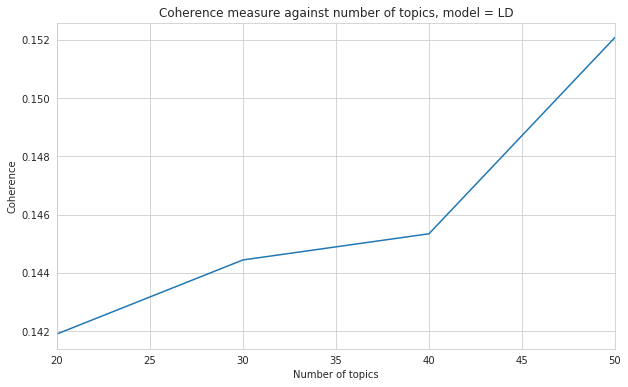

In [45]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(Ks, coherences_ld, ax = ax)
ax.set(xlim=(20,50),xlabel="Number of topics",ylabel="Coherence", title="Coherence measure against number of topics, model = {}".format(method))
plt.show

<function matplotlib.pyplot.show>

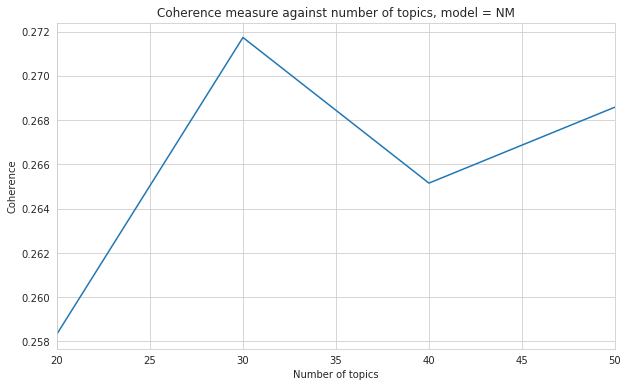

In [49]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(Ks, coherences_nm, ax = ax)
ax.set(xlim=(20,50),xlabel="Number of topics",ylabel="Coherence", title="Coherence measure against number of topics, model = {}".format(method_2))
plt.show